# Programming Exercise 5:
# Regularized Linear Regression and Bias vs Variance

## Introduction


In [146]:

#Ref: https://github.com/TingNie/Coursera-ML-using-matlab-python/blob/master/coursera_ml_ipynb/ex5/ex5.ipynb

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import sys
sys.path.append('..')

# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [147]:
#from Utils.py
def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x


In [148]:
#from Utils.py
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

In [149]:
#from Utils.py
def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    pyplot.plot(x, np.dot(X_poly, theta), '--', lw=2)


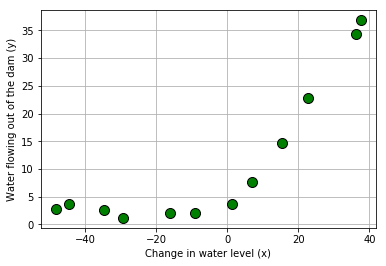

In [151]:
# Load from ex5data1.mat, where all variables will be store in a dictionary
path='ML/ex5data1.mat'
data = loadmat(path)

#data = loadmat(os.path.join('Data', 'ex5data1.mat'))
# Extract train, test, validation data from dictionary
# and also convert y's form 2-D matrix (MATLAB format) to a numpy vector
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]
# m = Number of examples
m = y.size
# Plot training data
pyplot.plot(X, y, 'go', ms=10, mec='k', mew=1)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)');
pyplot.grid(True)

### 1.2 Regularized linear regression cost function

In [152]:
def computeCost(X, y, theta,lambda_):
    cost=0
    reg=0
    m=len(X)
    cost = np.sum(np.power(((X.dot(theta.T)) - y), 2)) / (2 * m)
    #reg = (lambda_/2*m)*np.sum(np.power(theta,2))
    cost=cost+reg
    return cost

In [153]:
def linearRegCostFunction(X, y, theta, lambda_):
    # Initialize some useful values
    m = y.size # number of training examples
    alpha = 0.001
    iters = 100
    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    
    cost = np.zeros(m)
    for i in range(iters):
        grad = grad - (alpha/len(X)) * np.sum(X.T * (X @ grad.T - y),axis=1)
        if i>0:
            grad = grad - (alpha/len(X)) * np.sum(X.T * (X @ grad.T - y),axis=1)
            grad = grad+((lambda_/len(X))*theta)
        J = computeCost(X, y, theta,lambda_)
            
    return J, grad

In [155]:
theta = np.array([1, 1])
J, _ = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)
print('Cost at theta = [1, 1]:\t   %f ' % J)
print('This value should be about 303.993192)\n' % J)

Cost at theta = [1, 1]:	   303.951526 
This value should be about 303.993192)



### 1.3 Regularized linear regression gradient

In [190]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 0)
#J, grad = reglinearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 0)
#print (J, grad)
print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Gradient at theta = [1, 1]:  [2.295994, 0.303056] 
 (this value should be about [-15.303016, 598.250744])



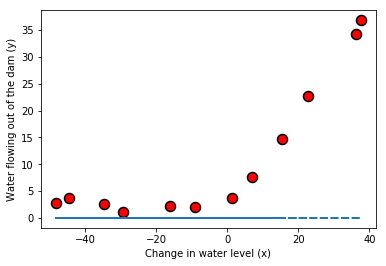

In [191]:
# add a columns of ones for the y-intercept
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

#  Plot fit over the data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.plot(X, np.dot(X_aug, theta), '--', lw=2);

<a id="section3"></a>
## 2 Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1 Learning Curves

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in the function `learningCurve` in the next cell, so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set `X`. Specifically, for a training set size of $i$, you should use the first $i$ examples (i.e., `X[:i, :]`
and `y[:i]`).

You can use the `trainLinearReg` function (by calling `utils.trainLinearReg(...)`) to find the $\theta$ parameters. Note that the `lambda_` is passed as a parameter to the `learningCurve` function.
After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., `X[:n,:]` and `y[:n]`) instead of the entire training set. However, for the cross validation error, you should compute it over the entire cross validation set. You should store
the computed errors in the vectors error train and error val.

<a id="func2"></a>

In [192]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    error_val= np.power(((Xval.dot(theta.T)) - yval), 2)
    error_train= np.power(((X.dot(theta.T)) - y), 2)

        
    # =============================================================
    return error_train, error_val

When you are finished implementing the function `learningCurve`, executing the next cell prints the learning curves and produce a plot similar to the figure below. 

![](Figures/learning_curve.png)

In the learning curve figure, you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model - the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

# Training Examples	Train Error	Cross Validation Error
  	1		4.555281	17.390585
  	2		1.376531	16.542627
  	3		1180.548384	1015.892437
  	4		1357.034941	112.862071
  	5		7.890285	1013.532251
  	6		4.498948	24.595348
  	7		216.391994	19.816732
  	8		6.833960	496.234364
  	9		13.988884	0.000000
  	10		13.925520	420.405879
  	11		58.181180	14.886824
  	12		517.672994	375.005274


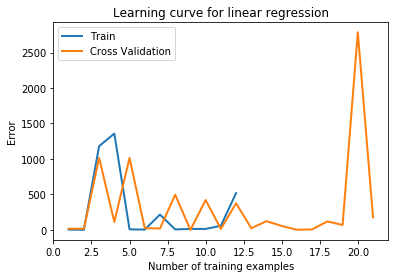

In [196]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)
#pyplot.plot(np.arange(1,m+10),error_val)
pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+10), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
#pyplot.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

<a id="section4"></a>

## 3 Polynomial regression

The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the code in the function `polyFeatures` in the next cell. The function should map the original training set $X$ of size $m \times 1$ into its higher powers. Specifically, when a training set $X$ of size $m \times 1$ is passed into the function, the function should return a $m \times p$ matrix `X_poly`, where column 1 holds the original values of X, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on. Note that you don’t have to account for the zero-eth power in this function.

<a id="polyFeatures"></a>

In [207]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros((X.shape[0], p))

    # ====================== YOUR CODE HERE ======================
    X_poly = X.copy()
    i=0
    for i in range(p):
        
        dim =i
       
        X_poly = np.insert(X_poly,len(X),np.power(X_poly,dim),axis=0)
        print (X_poly)
    # ============================================================
    return X_poly

Now you have a function that will map features to a higher dimension. The next cell will apply it to the training set, the test set, and the cross validation set.

In [208]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly])

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test])

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val])

print('Normalized Training Example 1:')
X_poly.shape

[[-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]
 [ -8.94145794]
 [ 15.30779289]
 [-34.70626581]
 [  1.38915437]
 [-44.38375985]
 [  7.01350208]
 [ 22.76274892]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]]
[[-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]
 [ -8.94145794]
 [ 15.30779289]
 [-34.70626581]
 [  1.38915437]
 [-44.38375985]
 [  7.01350208]
 [ 22.76274892]
 [-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]
 [ -8.94145794]
 [ 15.30779289]
 [-34.70626581]
 [  1.38915437]
 [-44.38375985]
 [  7.01350208]
 [ 22.76274892]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1.        ]
 [  1. 

/Users/saishibu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in power
/Users/saishibu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/Users/saishibu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in subtract
  # Remove the CWD from sys.path while we load stuff.
/Users/saishibu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


(3084, 1)

In [209]:
lambda_ = 100
theta = trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=55)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

utils.plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

ValueError: operands could not be broadcast together with shapes (3084,) (12,) 

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In the next section, you will get to  try different $\lambda$ parameters to see how regularization can lead to a better model.

### 3.2 Adjusting the regularization parameter

In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the the lambda parameter and try $\lambda = 1, 100$. For each of these values, the script should generate a polynomial fit to the data and also a learning curve.

For $\lambda = 1$, the generated plots should look like the the figure below. You should see a polynomial fit that follows the data trend well (left) and a learning curve (right) showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

<table>
    <tr>
        <td><img src="Figures/polynomial_regression_reg_1.png"></td>
        <td><img src="Figures/polynomial_learning_curve_reg_1.png"></td>
    </tr>
</table>

For $\lambda = 100$, you should see a polynomial fit (figure below) that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

![](Figures/polynomial_regression_reg_100.png)

*You do not need to submit any solutions for this optional (ungraded) exercise.*

<a id="section5"></a>
### 3.3 Selecting $\lambda$ using a cross validation set

From the previous parts of the exercise, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda = 1$) can provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$ parameter. Concretely, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate
how well the model will perform on actual unseen data. 

Your task is to complete the code in the function `validationCurve`. Specifically, you should should use the `utils.trainLinearReg` function to train the model using different values of $\lambda$ and compute the training error and cross validation error. You should try $\lambda$ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}.
<a id="validationCurve"></a>

In [210]:
def validationCurve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda_.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross validation.
    
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    
    error_val : list
        The validation error computed at each value for the regularization
        parameter.
    
    Instructions
    ------------
    Fill in this function to return training errors in `error_train` and
    the validation errors in `error_val`. The vector `lambda_vec` contains
    the different lambda parameters to use for each calculation of the
    errors, i.e, `error_train[i]`, and `error_val[i]` should give you the
    errors obtained after training with `lambda_ = lambda_vec[i]`.

    Note
    ----
    You can loop over lambda_vec with the following:
    
          for i in range(len(lambda_vec))
              lambda = lambda_vec[i]
              # Compute train / val errors when training linear 
              # regression with regularization parameter lambda_
              # You should store the result in error_train[i]
              # and error_val[i]
              ....
    """
    # Selected values of lambda (you should not change this)
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # You need to return these variables correctly.
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))

    # ====================== YOUR CODE HERE ======================
    error_train=trainLinearReg(linearRegCostFunction, X_poly_test, y, lambda_=0.0, maxiter=200)
    error_val=trainLinearReg(linearRegCostFunction, X_poly_val, y, lambda_=0.0, maxiter=200)

    # ============================================================
    return lambda_vec, error_train, error_val

After you have completed the code, the next cell will run your function and plot a cross validation curve of error v.s. $\lambda$ that allows you select which $\lambda$ parameter to use. You should see a plot similar to the figure below. 

![](Figures/cross_validation.png)

In this figure, we can see that the best value of $\lambda$ is around 3. Due to randomness
in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

In [211]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

ValueError: operands could not be broadcast together with shapes (5397,) (12,) 

### 3.4  Computing test set error

In the previous part of the exercise, you implemented code to compute the cross validation error for various values of the regularization parameter $\lambda$. However, to get a better indication of the model’s performance in the real world, it is important to evaluate the “final” model on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$). For this optional (ungraded) exercise, you should compute the test error using the best value of $\lambda$ you found. In our cross validation, we obtained a test error of 3.8599 for $\lambda = 3$.

*You do not need to submit any solutions for this optional (ungraded) exercise.*

### 3.5 Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for $i$ examples, you should first randomly select $i$ examples from the training set and $i$ examples from the cross validation set. You will then learn the parameters $\theta$ using the randomly chosen training set and evaluate the parameters $\theta$ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for $i$ examples.

For this optional (ungraded) exercise, you should implement the above strategy for computing the learning curves. For reference, the figure below  shows the learning curve we obtained for polynomial regression with $\lambda = 0.01$. Your figure may differ slightly due to the random selection of examples.

![](Figures/learning_curve_random.png)

